## Melting temperature workflow

- ~~Macro for free energy calculation~~
- ~~Get a simple while loop for FE working~~
- Do TS runs instead of FE runs in while loop, terminate after #iterations
- Do solid calculations in loop, stop if melted, change temp range
- Add liquid to the mix, stop if frozen, change temp range
- Add node for initial guess
- Check Tm exists, stop if found, else change temp range by extrapolation
- Test the routine

In [1]:
from pyiron_workflow import Workflow
import numpy as np
import matplotlib.pyplot as plt
import pyiron_workflow as pwf

In [2]:
from calphy_nodes import RunFreeEnergy, InputClass

In [3]:
@Workflow.wrap.as_function_node
def increment_temperature(temperature,  
                          increment):
    new_temperature = temperature + increment
    return new_temperature

@Workflow.wrap.as_function_node
def increment_iterations(iteration):
    new_iteration = iteration + 1
    return new_iteration

In [4]:
@Workflow.wrap.as_macro_node
def WhileRunFreeEnergy(wf, inp, 
                       species: str, 
                       potential: str,
                       temperature: float,
                       increment: float,
                       max_temperature: float):
    wf.free_energy = RunFreeEnergy(inp,
                                  species,
                                  potential,
                                  temperature)
    wf.increment_temperature = increment_temperature(wf.free_energy.outputs.temperature,
                                            increment)
    wf.free_energy.inputs.temperature = wf.increment_temperature.outputs.new_temperature
    wf.condition = pwf.standard_nodes.LessThan(wf.free_energy.outputs.incremented_temp, 
                                               max_temperature)
    
    wf.switch = pwf.standard_nodes.If()
    wf.switch.inputs.condition = wf.condition
    
    wf.starting_nodes = [wf.free_energy]
    wf.free_energy >> wf.increment_temperature >> wf.condition >> wf.switch
    wf.switch.signals.output.true >> wf.free_energy
    return wf.free_energy

In [5]:
inp = InputClass(temperature=800,
                pressure=0,
                reference_phase = 'solid',
                mode = 'fe',
                equilibration_control = 'berendsen',
                )
inp.queue.cores = 4	

In [6]:
macro = WhileRunFreeEnergy(inp,
                          'Cu',
                          '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2',
                           800.,
                           100.,
                           1000.
                          )
#macro = RunFreeEnergy(inp,
#                          'Cu',
#                          '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2',
#                           800.,)

AttributeError: Could not find attribute incremented_temp on OutputsWithInjection object nor in its channels (['temperature'])

In [7]:
macro.run()

NameError: name 'macro' is not defined

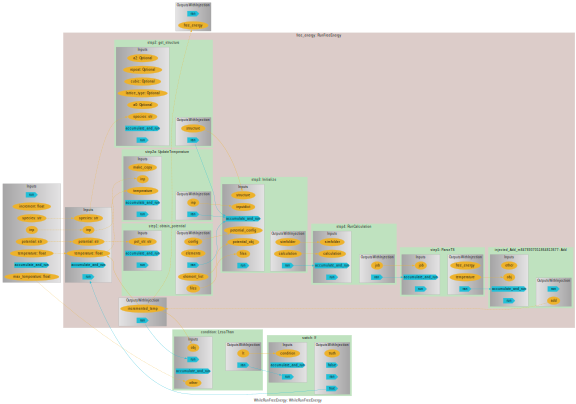

In [14]:
macro.draw(size=(8,8), depth=2)